In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.preprocessing import image

#create labels

In [ ]:

classes=[]
filename='/content/drive/MyDrive/liver dataset'
for sub_folder in os.listdir(os.path.join(filename,'train')):
    classes.append(sub_folder)
print(classes)

#resize images and put together Training and Testing folder
from tqdm import tqdm

X_train = []
y_train = []
image_size = 224

for i in classes:


    path_test = os.path.join(filename,'val',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)

X_train = np.array(X_train)
y_train = np.array(y_train)


['malignant', 'benign']


100%|██████████| 20/20 [00:04<00:00,  4.09it/s]


In [ ]:

from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#data augmentation

datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)

datagen.fit(X_train)

#X_train.shape
lb = LabelEncoder()


In [ ]:

#train and test splitting
#X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.60,random_state=42,stratify=y_train)
from tensorflow.keras.utils import to_categorical
labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_train1 = to_categorical(y_train)
#y_test=lb.transform(y_test)

print(len(X_train))
print(len(y_train))


41
41


In [ ]:

#Moulding train images

train_datagen = image.ImageDataGenerator(rescale = 1./255, shear_range = 0.2,zoom_range = 0.2, horizontal_flip = True)

test_dataset = image.ImageDataGenerator()



#Reshaping test and validation images
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/liver dataset/train',
    target_size = (224,224),
    batch_size = 10,
    class_mode = 'binary')
validation_generator = test_dataset.flow_from_directory(
    '/content/drive/MyDrive/liver dataset/val',
    target_size = (224,224),
    batch_size = 10,
    class_mode = 'binary')


Found 246 images belonging to 2 classes.
Found 41 images belonging to 2 classes.


In [ ]:

def identity_block(X, f, filters, stage, block):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X



In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [ ]:

def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model


In [ ]:

base_model = ResNet50(input_shape=(224, 224, 3))

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM

headModel = base_model.output
headModel = Flatten()(headModel)

headModel=Dense(64, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

model = Model(inputs=base_model.input, outputs=headModel)

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])



In [ ]:

base_model.load_weights("/content/drive/MyDrive/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

for layer in base_model.layers:
    layer.trainable = False

for layer in model.layers:
    print(layer, layer.trainable)

es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30)


mc = ModelCheckpoint('model.h5', monitor='val_accuracy')

print(y_train)


<keras.engine.input_layer.InputLayer object at 0x7f819e49adf0> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f819e489ca0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f81a5597460> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f81a559b640> False
<keras.layers.core.activation.Activation object at 0x7f819dbf6eb0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f819db7b160> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f819d454970> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f819d45d4f0> False
<keras.layers.core.activation.Activation object at 0x7f819d45d910> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f819db7ba60> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f81a559b370> False
<keras.layers.core.activation.Activation object at 0x7f819d4627f0> False
<keras.layers.convolutional

In [ ]:
H = model.fit_generator(train_generator,validation_data=validation_generator,epochs=15,verbose=1,callbacks=[mc,es])


<ipython-input-13-4972ef2d9e18>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(train_generator,validation_data=validation_generator,epochs=15,verbose=1,callbacks=[mc,es])


Epoch 1/15
25/25 [==============================] - 86s 1s/step - loss: 0.9873 - accuracy: 0.8618 - val_loss: 85.2253 - val_accuracy: 0.5122
Epoch 2/15
25/25 [==============================] - 10s 421ms/step - loss: 0.2849 - accuracy: 0.9472 - val_loss: 36462.9648 - val_accuracy: 0.4878
Epoch 3/15
25/25 [==============================] - 10s 402ms/step - loss: 0.6188 - accuracy: 0.8618 - val_loss: 7522.9907 - val_accuracy: 0.5122
Epoch 4/15
25/25 [==============================] - 9s 351ms/step - loss: 0.0265 - accuracy: 1.0000 - val_loss: 976.9365 - val_accuracy: 0.5122
Epoch 5/15
25/25 [==============================] - 10s 407ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 172.6149 - val_accuracy: 0.5122
Epoch 6/15
25/25 [==============================] - 10s 402ms/step - loss: 0.3409 - accuracy: 0.9065 - val_loss: 26.1689 - val_accuracy: 0.4390
Epoch 7/15
25/25 [==============================] - 9s 355ms/step - loss: 0.1937 - accuracy: 0.9268 - val_loss: 1074.5901 - val_accur

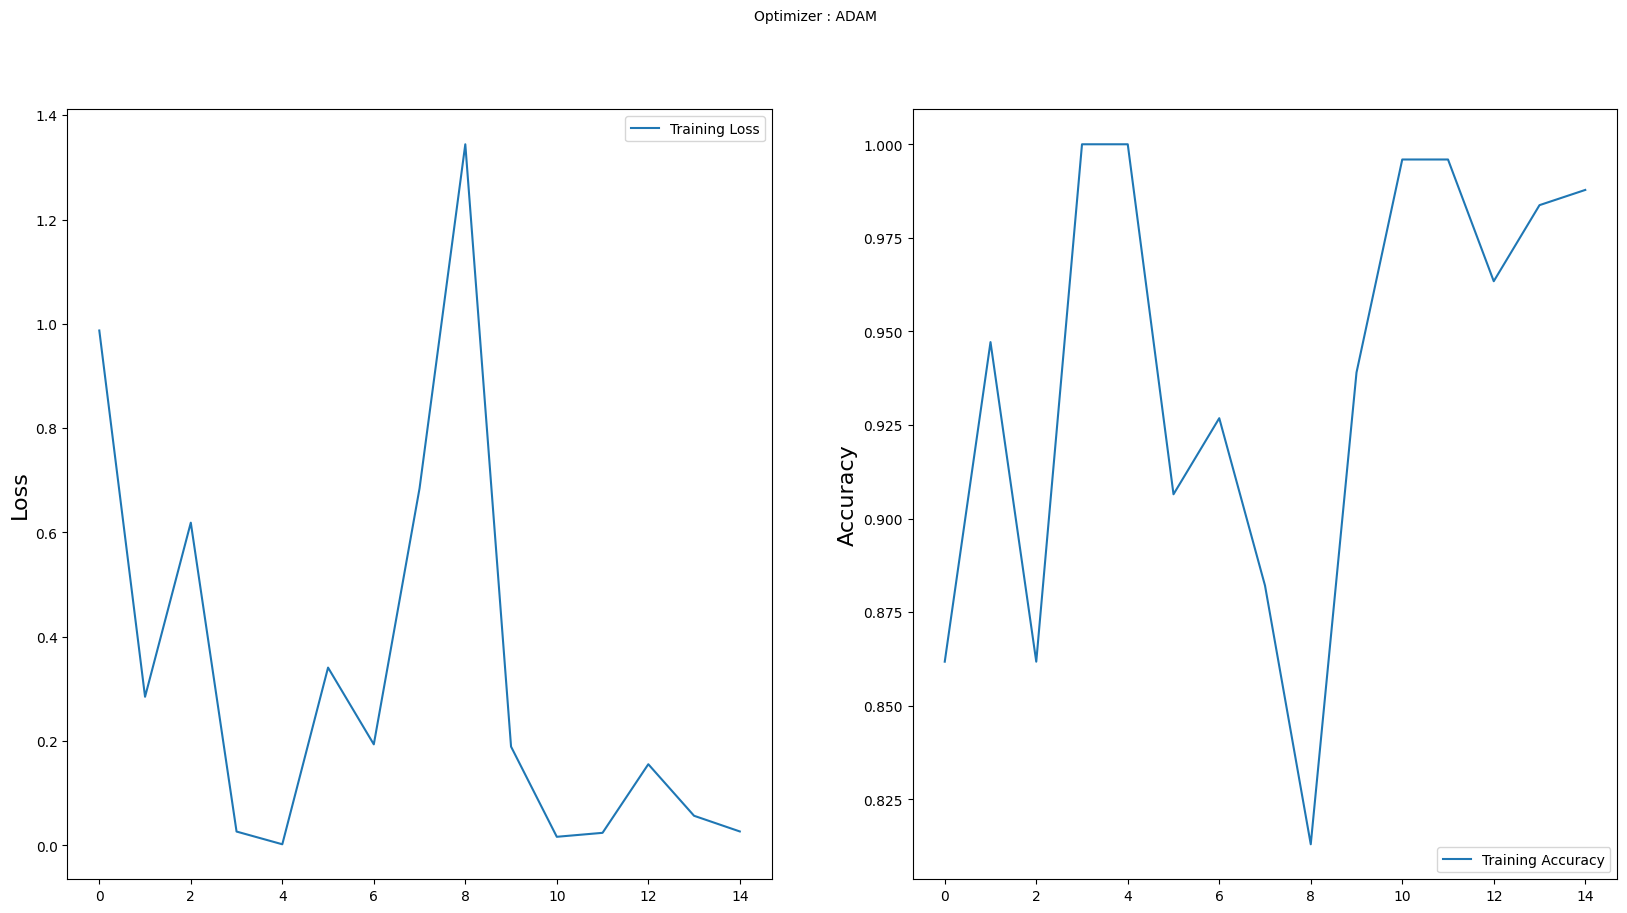

In [ ]:

import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : ADAM ', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(H.history['loss'], label='Training Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(H.history['accuracy'], label='Training Accuracy')
plt.legend(loc='lower right')
plt.show()
